In [1]:
import tensorflow as tf
import numpy as np
import DataSets as ds
import Layers
import matplotlib.pyplot as plt

/home/b/anaconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


In [2]:
def get_dict(database,IsTrainingMode):
    xs,ys = database.NextTrainingBatch()
    return {x:xs,y_desired:ys,ITM:IsTrainingMode}

In [3]:
LoadModel = False
KeepProb_Dropout = 1

In [4]:
experiment_name = '10k_Dr{}'.format(KeepProb_Dropout)
train = ds.DataSet('../Databases/data_10k.bin','../Databases/gender_10k.bin',10000, batchSize=512)
test = ds.DataSet('../Databases/data_test10k.bin','../Databases/gender_test10k.bin',10000, batchSize=512)

nb data :  10000
nb data :  10000


In [5]:
x,labels = train.NextTrainingBatch()

In [6]:
def plot_gallery(images, n_row=4, n_col=4, title= 'gallery'):
    n_components = n_row * n_col
    image_shape = (48, 48)
    images = images[:n_components]
    """Plot images as gallery"""
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp < 0)
        if len(dmy[0]) > 0:
            yz, xz = dmy
        comp[comp < 0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0]) > 0:
            plt.plot(xz, yz, 'r,', hold=True)
            print(len(dmy[0]), "negative-valued pixels")

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

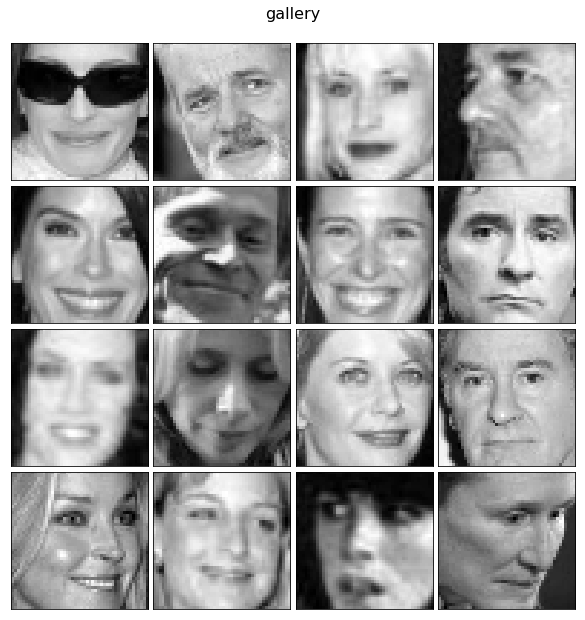

In [7]:
plot_gallery(x)

In [8]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, train.dim],name='x')
    y_desired = tf.placeholder(tf.float32, [None, 2],name='y_desired')
    ITM = tf.placeholder("bool", name='Is_Training_Mode')

In [9]:
with tf.name_scope('CNN'):
    t = tf.reshape(x,(-1,48,48,1))
    t = tf.layers.batch_normalization(t, training=ITM)
    t = tf.layers.Conv2D(32, (3,3), strides=(1,1), activation=tf.nn.relu)(t)
    t = tf.nn.max_pool(t, (1,3,3,1), (1,3,3,1), padding='SAME')
    t = tf.keras.layers.Dropout(0.5)(t)
    t = tf.layers.Conv2D(64, (3,3), strides=(1,1), activation=tf.nn.relu)(t)
    t = tf.nn.max_pool(t, (1,3,3,1), (1,3,3,1), padding='SAME')
    t = tf.keras.layers.Dropout(0.5)(t)
#     t = tf.layers.Conv2D(8, (3,3), strides=(1,1), activation=tf.nn.relu)(t)
#     t = tf.nn.max_pool(t, (1,3,3,1), (1,3,3,1), padding='SAME')
    f = tf.layers.flatten(t)
    d = tf.layers.Dense(10, activation='relu')(f)
    y = tf.layers.Dense(2, activation=tf.nn.log_softmax)(d)
    

with tf.name_scope('cross_entropy'):
    diff = y_desired * y 
    with tf.name_scope('total'):
        cross_entropy = -tf.reduce_mean(diff)
    tf.summary.scalar('cross_entropy', cross_entropy)    
    
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_desired, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)    

with tf.name_scope('learning_rate'):
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(1e-3,global_step,1000, 0.75, staircase=True)


with tf.name_scope('learning_rate'):
    tf.summary.scalar('learning_rate', learning_rate)

In [10]:
# for x in [t,a,b,c, b2, c2]:
#     print(x)

In [12]:
# with tf.name_scope('CNN'):
#     t = Layers.unflat(x,48,48,1)
#     nbfilter = 16
#     for k in range(4):
#         for i in range(2):
#             t = tf.layers.batch_normalization(t, training=ITM)
#             t = Layers.conv(t,nbfilter,3,1,ITM,'conv_%d_%d'%(nbfilter,i),KeepProb_Dropout)
#         t = Layers.maxpool(t,2,'pool')
#         nbfilter *= 2
    
#     t = Layers.flat(t)
#     #t = Layers.fc(t,50,ITM,'fc_1',KeepProb_Dropout)
#     y = Layers.fc(t,2,ITM,'fc_2',KP_dropout=1.0,act=tf.nn.log_softmax)

# with tf.name_scope('cross_entropy'):
#     diff = y_desired * y 
#     with tf.name_scope('total'):
#         cross_entropy = -tf.reduce_mean(diff)
#     tf.summary.scalar('cross entropy', cross_entropy)    
    
# with tf.name_scope('accuracy'):
#     with tf.name_scope('correct_prediction'):
#         correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_desired, 1))
#     with tf.name_scope('accuracy'):
#         accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#     tf.summary.scalar('accuracy', accuracy)    

# with tf.name_scope('learning_rate'):
#     global_step = tf.Variable(0, trainable=False)
#     learning_rate = tf.train.exponential_decay(1e-3,global_step,1000, 0.75, staircase=True)


# with tf.name_scope('learning_rate'):
#     tf.summary.scalar('learning_rate', learning_rate)

In [11]:
#train_step = tf.train.GradientDescentOptimizer(0.00001).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)
merged = tf.summary.merge_all()

Acc_Train = tf.placeholder("float", name='Acc_Train');
Acc_Test = tf.placeholder("float", name='Acc_Test');
MeanAcc_summary = tf.summary.merge([tf.summary.scalar('Acc_Train', Acc_Train),tf.summary.scalar('Acc_Test', Acc_Test)])


print ("-----------------------------------------------------")
print ("-----------",experiment_name)
print ("-----------------------------------------------------")

sess = tf.Session()	
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(experiment_name, sess.graph)
saver = tf.train.Saver()
if LoadModel:
	saver.restore(sess, "./model.ckpt")

nbIt = 5000
for it in range(nbIt):
    trainDict = get_dict(train,IsTrainingMode=1)
    sess.run(train_step, feed_dict=trainDict)
    
    if it%10 == 0:
        acc,ce,lr = sess.run([accuracy,cross_entropy,learning_rate], feed_dict=trainDict)
        print ("it= %6d - rate= %f - cross_entropy= %f - acc= %f" % (it,lr,ce,acc ))
        summary_merged = sess.run(merged, feed_dict=trainDict)
        writer.add_summary(summary_merged, it)	

    if it%100 == 50:
        Acc_Train_value = train.mean_accuracy(sess,accuracy,x,y_desired,ITM)
        Acc_Test_value = test.mean_accuracy(sess,accuracy,x,y_desired,ITM)
        print ("mean accuracy train = %f  test = %f" % (Acc_Train_value,Acc_Test_value ))
        summary_acc = sess.run(MeanAcc_summary, feed_dict={Acc_Train:Acc_Train_value,Acc_Test:Acc_Test_value})
        writer.add_summary(summary_acc, it)

writer.close()
if not LoadModel:
    saver.save(sess, "./model.ckpt")
sess.close()

-----------------------------------------------------
----------- 10k_Dr1
-----------------------------------------------------
it=      0 - rate= 0.001000 - cross_entropy= 0.337999 - acc= 0.552734
it=     10 - rate= 0.001000 - cross_entropy= 0.331770 - acc= 0.582031
it=     20 - rate= 0.001000 - cross_entropy= 0.301042 - acc= 0.687500
it=     30 - rate= 0.001000 - cross_entropy= 0.281368 - acc= 0.724609
it=     40 - rate= 0.001000 - cross_entropy= 0.244261 - acc= 0.792969
it=     50 - rate= 0.001000 - cross_entropy= 0.253756 - acc= 0.755859
mean accuracy train = 0.708500  test = 0.709200
it=     60 - rate= 0.001000 - cross_entropy= 0.230957 - acc= 0.826172
it=     70 - rate= 0.001000 - cross_entropy= 0.229234 - acc= 0.800781
it=     80 - rate= 0.001000 - cross_entropy= 0.217346 - acc= 0.828125
it=     90 - rate= 0.001000 - cross_entropy= 0.210192 - acc= 0.824219
it=    100 - rate= 0.001000 - cross_entropy= 0.207958 - acc= 0.843750
it=    110 - rate= 0.001000 - cross_entropy= 0.225213 

KeyboardInterrupt: 

In [55]:
g = get_dict(train,IsTrainingMode=True)
g.keys()

dict_keys([<tf.Tensor 'input_1/x:0' shape=(?, 2304) dtype=float32>, <tf.Tensor 'input_1/y_desired:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'input_1/Is_Training_Mode:0' shape=<unknown> dtype=bool>])